### Importing cleaned dataframes 

In [59]:
import pandas as pd
import logging
import sys
import numpy as np
from dataclasses import asdict
from pathlib import Path

path = r"C:\Users\giuli\Repositories\intraday-momentum\src"
sys.path.append(path)

from classes.metrics.metrics import MetricsCalculator
from classes.backtest.engine import BacktestEngine  
from classes.backtest.default import BacktestDefaults 

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    force=True,
)

logger = logging.getLogger(__name__)


In [60]:
root = Path(r"C:/Users/giuli/Repositories/intraday-momentum")

df_spy = pd.read_pickle(root / "data/cleaned/intraday_sp500.pkl")
df_dividends = pd.read_csv(root / "data/cleaned/SPY_dividends_2022-05-09_2024-04-22.csv")
df_spy_daily = pd.read_pickle(root / "data/cleaned/daily_sp500.pkl")

# Print information about the dataframes
df_spy.info()
print("\n")
df_dividends.info()
print("\n")
df_spy_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36754 entries, 2023-12-06 14:30:00+00:00 to 2024-04-22 20:00:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   volume  36754 non-null  float64
 1   open    36754 non-null  float64
 2   high    36754 non-null  float64
 3   low     36754 non-null  float64
 4   close   36754 non-null  float64
dtypes: float64(5)
memory usage: 1.7 MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cash_amount       8 non-null      float64
 1   currency          8 non-null      object 
 2   declaration_date  8 non-null      object 
 3   dividend_type     8 non-null      object 
 4   ex_dividend_date  8 non-null      object 
 5   frequency         8 non-null      int64  
 6   id                8 non-null      object 
 7   pay_date       

In [61]:
dfs = {
    "df_spy": df_spy,
    "df_spy_daily": df_spy_daily,
}

for name, df in dfs.items():
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError(f"{name}: index must be a DatetimeIndex.")
    else:
        logger.info(f"{name}: index is a valid DatetimeIndex with timezone={df.index.tz}.")


2025-12-06 11:44:45,222 | INFO | df_spy: index is a valid DatetimeIndex with timezone=UTC.
2025-12-06 11:44:45,222 | INFO | df_spy_daily: index is a valid DatetimeIndex with timezone=UTC.


### Add key variables

In [62]:
df_spy[500:510]


,volume,open,high,low,close
Datetime,,,,,
2023-12-07 16:19:00+00:00,254715.0,456.7300,456.7700,456.5120,456.7200
2023-12-07 16:20:00+00:00,193111.0,456.7100,456.8200,456.6797,456.8200
2023-12-07 16:21:00+00:00,247104.0,456.8300,456.9499,456.8100,456.8780
2023-12-07 16:22:00+00:00,134138.0,456.8700,456.9500,456.8250,456.9000
2023-12-07 16:23:00+00:00,93536.0,456.8999,457.0000,456.8999,456.9300
2023-12-07 16:24:00+00:00,130343.0,456.9295,456.9550,456.7993,456.8900
2023-12-07 16:25:00+00:00,84173.0,456.8750,457.0200,456.8720,456.9663
2023-12-07 16:26:00+00:00,67431.0,456.9900,457.1200,456.9550,457.0750
2023-12-07 16:27:00+00:00,84515.0,457.0750,457.1280,457.0200,457.1229


In [63]:
df_spy

,volume,open,high,low,close
Datetime,,,,,
2023-12-06 14:30:00+00:00,591773.0,458.810,458.8400,458.550,458.660
2023-12-06 14:31:00+00:00,200382.0,458.660,458.8000,458.590,458.720
2023-12-06 14:32:00+00:00,209659.0,458.730,458.8325,458.550,458.600
2023-12-06 14:33:00+00:00,178804.0,458.600,458.6300,458.490,458.565
2023-12-06 14:34:00+00:00,127867.0,458.560,458.6400,458.385,458.400
...,...,...,...,...,...
2024-04-22 19:56:00+00:00,610685.0,499.350,499.5300,499.305,499.450
2024-04-22 19:57:00+00:00,469276.0,499.445,499.4450,499.160,499.245
2024-04-22 19:58:00+00:00,942709.0,499.250,499.2500,498.905,499.015


In [64]:
print(df_dividends.columns.tolist())


['cash_amount', 'currency', 'declaration_date', 'dividend_type', 'ex_dividend_date', 'frequency', 'id', 'pay_date', 'record_date', 'ticker']


In [65]:
# Make a copy
df_dividends_prepared = df_dividends.copy()

# Rename columns to match what MetricsCalculator expects
df_dividends_prepared = df_dividends_prepared.rename(columns={
    "ex_dividend_date": "caldt",  # Metrics expects 'caldt'
    "cash_amount": "dividend"     # Metrics expects 'dividend'
})

# Convert 'caldt' to datetime
df_dividends_prepared["caldt"] = pd.to_datetime(df_dividends_prepared["caldt"])

# Keep only the necessary columns
df_dividends_prepared = df_dividends_prepared[["caldt", "dividend", "ticker"]]

# Verify
print(df_dividends_prepared.head())
print(df_dividends_prepared.columns)


       caldt  dividend ticker
0 2023-12-15  1.906073    SPY
1 2023-09-15  1.583169    SPY
2 2023-06-16  1.638367    SPY
3 2023-03-17  1.506204    SPY
4 2024-12-20  1.965548    SPY
Index(['caldt', 'dividend', 'ticker'], dtype='object')


In [66]:
mc = MetricsCalculator()
df_spy, df_spy_daily = mc.from_clean_df(df_spy, df_dividends_prepared)
mc.quality_check(df_spy, df_spy_daily)
mc.logger.info("All SPY metrics successfully computed.")


2025-12-06 11:44:58,273 | INFO | Starting computation of market microstructure metrics...
2025-12-06 11:44:58,777 | INFO | Running quality checks...
2025-12-06 11:44:58,786 | INFO | NaN summary:
log_returns    1
RV             0
BV             0
vwap           0
price          0
day            0
dtype: int64
2025-12-06 11:44:58,786 | INFO | df_all_days shape: (36754, 21)
2025-12-06 11:44:58,786 | INFO | df_daily_profiles shape: (36754, 22)
2025-12-06 11:44:58,832 | INFO | df_all saved to data/processed/df_all_days.pkl
2025-12-06 11:44:58,869 | INFO | df_daily saved to data/processed/df_daily_groups.pkl
2025-12-06 11:44:58,869 | INFO | Running quality checks...
2025-12-06 11:44:58,869 | INFO | NaN summary:
log_returns    1
RV             0
BV             0
vwap           0
price          0
day            0
dtype: int64
2025-12-06 11:44:58,869 | INFO | df_all_days shape: (36754, 21)
2025-12-06 11:44:58,880 | INFO | df_daily_profiles shape: (36754, 22)
2025-12-06 11:44:58,880 | INFO | All

In [73]:
# Inspect intraday SPY dataframe
print("---------- df_spy ----------\n")
print(df_spy.info())
print("\nSummary statistics:\n")
print(df_spy.describe())
print("\nMissing values:\n")
print(df_spy.isnull().sum())
print("\nFirst rows:\n")
print(df_spy.head())

print("\n---------- df_daily ----------\n")

# Inspect daily SPY dataframe
print(df_spy_daily.info())
print("\nSummary statistics:\n")
print(df_spy_daily.describe())
print("\nMissing values:\n")
print(df_spy_daily.isnull().sum())
print("\nFirst rows:\n")
print(df_spy_daily.head())


---------- df_spy ----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36754 entries, 0 to 36753
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   timestamp               36754 non-null  datetime64[ns, UTC]
 1   volume                  36754 non-null  float64            
 2   open                    36754 non-null  float64            
 3   high                    36754 non-null  float64            
 4   low                     36754 non-null  float64            
 5   close                   36754 non-null  float64            
 6   day                     36754 non-null  object             
 7   log_returns             36753 non-null  float64            
 8   RV                      36754 non-null  float64            
 9   BV                      36754 non-null  float64            
 10  price                   36754 non-null  float64            
 11  vwap       

In [79]:
import os

base_path = r"C:\Users\giuli\Repositories\intraday-momentum"
minute_path = os.path.join(base_path, "data", "cleaned", "intraday_sp500.pkl")
daily_path  = os.path.join(base_path, "data", "cleaned", "daily_sp500.pkl")

print("Minute path:", minute_path)
print("Daily path: ", daily_path)
print("Minute exists?", os.path.exists(minute_path))
print("Daily exists?", os.path.exists(daily_path))


Minute path: C:\Users\giuli\Repositories\intraday-momentum\data\cleaned\intraday_sp500.pkl
Daily path:  C:\Users\giuli\Repositories\intraday-momentum\data\cleaned\daily_sp500.pkl
Minute exists? True
Daily exists? True


In [81]:
import pandas as pd

# Example if your index is already datetime
if not "timestamp" in df_spy.columns:
    df_spy = df_spy.copy()
    if isinstance(df_spy.index, pd.DatetimeIndex):
        df_spy["timestamp"] = df_spy.index
    else:
        # If you have a column with the datetime, rename it
        df_spy["timestamp"] = pd.to_datetime(df_spy["your_datetime_column_here"])

# Create a 'day' column
df_spy["day"] = df_spy["timestamp"].dt.date

# Check
print(df_spy.head())


                  timestamp    volume    open      high      low    close  \
0 2023-12-06 14:30:00+00:00  591773.0  458.81  458.8400  458.550  458.660   
1 2023-12-06 14:31:00+00:00  200382.0  458.66  458.8000  458.590  458.720   
2 2023-12-06 14:32:00+00:00  209659.0  458.73  458.8325  458.550  458.600   
3 2023-12-06 14:33:00+00:00  178804.0  458.60  458.6300  458.490  458.565   
4 2023-12-06 14:34:00+00:00  127867.0  458.56  458.6400  458.385  458.400   

          day  log_returns        RV        BV  ...        vwap         hlc  \
0  2023-12-06          NaN  0.004575  0.000012  ...  458.683333  458.683333   
1  2023-12-06     0.000131  0.004575  0.000012  ...  458.688392  458.703333   
2  2023-12-06    -0.000262  0.004575  0.000012  ...  458.682625  458.660833   
3  2023-12-06    -0.000076  0.004575  0.000012  ...  458.664306  458.561667   
4  2023-12-06    -0.000360  0.004575  0.000012  ...  458.645807  458.475000   

   move_open  spy_dvol  spy_ret  min_from_open  minute_of_day 

In [82]:
minute_path = r"C:\Users\giuli\Repositories\intraday-momentum\data\cleaned\intraday_sp500_diff.pkl"
df_spy.to_pickle(minute_path)


In [83]:
defaults = BacktestDefaults(
    minute_path=minute_path,
    daily_path=daily_path,
    initial_aum=100_000.0,
    commission_rate=0.0035,
    min_comm_per_order=0.35,
    slippage_bps=0,
    band_mult=1.0,
    trade_freq=30,
    sizing_type="vol_target",
    target_vol=0.02,
    max_leverage=4.0,
)

engine = BacktestEngine()
trade_log_df, daily_pnl_df, equity_curve_df = engine.run_backtest(asdict(defaults))


[WARNING] Daily data at 'C:\Users\giuli\Repositories\intraday-momentum\data\cleaned\daily_sp500.pkl' is missing required columns: 'caldt' and/or 'close'.


2025-12-06 11:55:52,494 | INFO | Trade log saved to C:\Users\giuli\Repositories\intraday-momentum\src\data\processed\trade_log.csv
2025-12-06 11:55:52,494 | INFO | Daily PnL saved to C:\Users\giuli\Repositories\intraday-momentum\src\data\processed\daily_pnl.pkl


2025-12-06 11:59:36,387 | INFO | Dataframe correctly initialized
2025-12-06 11:59:36,388 | INFO | Computing comulative AUM for SPY
2025-12-06 11:59:36,664 | INFO | Plot saved to C:\Users\giuli\Repositories\intraday-momentum\outputs\figures\test_01


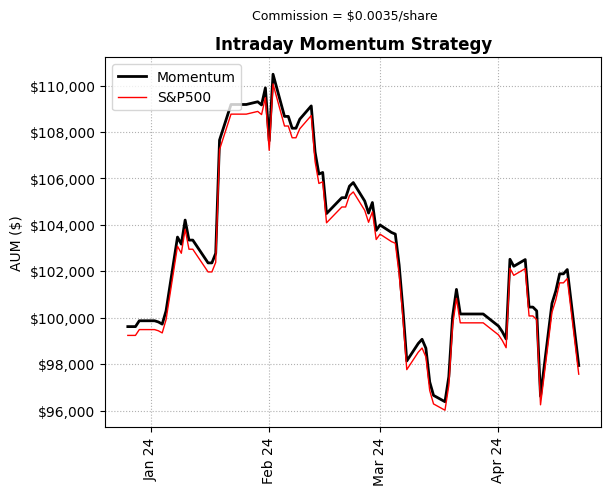

In [89]:
from pathlib import Path
import pandas as pd
from classes.viz.plotter import Plotter

# Paths
data_path = Path(r"C:\Users\giuli\Repositories\intraday-momentum\data\processed\daily_pnl.pkl")
output_path = Path(r"C:\Users\giuli\Repositories\intraday-momentum\outputs\figures") / "test_01"
output_path.mkdir(parents=True, exist_ok=True)

# Load data
df = pd.read_pickle(data_path)
df.index = pd.to_datetime(df.index)

# Plot cumulative returns
plott = Plotter(df)

# Use actual starting AUM to avoid ValueError
start_aum = df["AUM"].iloc[0]

plott.plot_cum_returns(
    ret_idx="ret",
    AUM_strat="AUM",
    file_name=str(output_path),
    AUM_0=start_aum
)


In [88]:
print(df["AUM"].head(5))
print(df["AUM"].iloc[0])


day
2023-12-26    99619.356
2023-12-27    99619.356
2023-12-28    99619.356
2023-12-29    99870.876
2024-01-02    99870.876
Name: AUM, dtype: float64
99619.35599999994


Weird ? I think the plotter is broken 

In [90]:
plott.compute_statistics("ret", "AUM", 0.000107 )

2025-12-06 11:59:43,883 | INFO | Computing returns and performance statistics such as Sharpe, Hit, Drawdown)


,Total Return (%),Annualized Return (%),Annualized Volatility (%),Sharpe Ratio,Hit Ratio (%),Maximum Drawdown (%)
Value,-2.0,-6.3,21.9,-0.31,46.0,13.0
